In [92]:
# 기본
import pandas as pd
import numpy as np 
import os
import warnings
warnings.filterwarnings("ignore")
import re

# 시각화 
import plotly.express as px
import matplotlib.pyplot as plt 
import seaborn as sns

# 모델
from sklearn.model_selection import (train_test_split, 
                                     KFold, 
                                     StratifiedKFold,
                                     GridSearchCV,
                                     RandomizedSearchCV)

from sklearn.mixture import GaussianMixture
from sklearn.tree import (DecisionTreeClassifier, 
                          DecisionTreeRegressor)

from sklearn.ensemble import (RandomForestClassifier, 
                              RandomForestRegressor)

from sklearn.svm import SVC

from xgboost import XGBClassifier

# sampling
from imblearn.over_sampling import SMOTE
from collections import Counter

# report
from sklearn import metrics
# matrix = metrics.confusion_matrix(y_test, y_pred)
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score

#encoder, scaler
from sklearn.preprocessing import (LabelEncoder, 
                                   OneHotEncoder, 
                                   StandardScaler,
                                   MinMaxScaler)

# imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# test
import statsmodels.api as sm 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [93]:
plt.rcParams['axes.unicode_minus'] = False
custom_params = {"axes.spines.right": False, "axes.spines.top": False}

sns.set_theme(context = 'talk',  
              style = 'darkgrid',  
              font = 'Malgun Gothic', 
              font_scale = 1.2,         
              rc = custom_params)

In [94]:
data = pd.read_csv('./data/data_res.csv', index_col = 0)

In [95]:
data = data.dropna(subset='업종분류')

In [97]:
df = data.drop(columns = '수요')

In [98]:
df.head(2)

,기업명,업종분류,사원수,설립연도,기업형태,매출액,주소,직무,자격요건,직급,이용하는기술스택/우대사항,해당 페이지 URL,기업 홈페이지 URL
0,젭,데이터베이스 및 온라인정보 제공업,NaN,2021.0,NaN,NaN,서울특별시 강남구,소프트웨어 엔지니어,"프로그래밍언어,열정,성실",3,"멀티,쓰레드,서버,웹,웹소켓,소켓,클라우드,구축,메타버스,AWS",https://www.wanted.co.kr/wd/180861,NaN
1,서커스컴퍼니,응용 소프트웨어 개발 및 공급업,20.0,2012.0,중소기업,170563.0,서울특별시 강남구,소프트웨어 엔지니어,"전공무관,공무,Node,Net,Nginx,Apache,SystemDesign,MyS...",0,"소프트웨어,객체지향,배포,자동화,프로젝트,서버,아키텍처,버전관리,AWS,EC,S,C...",https://www.wanted.co.kr/wd/207284,www.circuscompany.com


In [99]:
df_missing_cols = []
for col in df.isna().sum()[df.isna().sum() > 0].sort_values(ascending = False).index:
    df_missing_cols.append(col)

df_missing_cols

['사원수', '기업형태', '매출액', '기업 홈페이지 URL', '자격요건', '주소', '이용하는기술스택/우대사항']

In [100]:
categorical_cols = ['업종분류','기업형태','주소','직무','이용하는기술스택/우대사항', '자격요건']
bool_cols = []
numeric_cols = ['사원수', '설립연도','매출액','직급']

In [101]:
def cat_missing(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(columns = passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in df_missing_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    if passed_col in bool_cols:
        y = label_encoder.fit_transform(y)
        
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=777), add_indicator = True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestClassifier()

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    X = df_null.drop(columns = passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_classifier.predict(X)
        if passed_col in bool_cols:
            df_null[passed_col] = df_null[passed_col].map({0: False, 1: True})
        else:
            pass
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

def num_missing(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(columns = passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in df_missing_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])
    
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=777), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_regressor = RandomForestRegressor()

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)
    
    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_regressor.predict(X)
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

In [102]:
for col in df_missing_cols:
    if col in categorical_cols:
        df[col] = cat_missing(col)
    elif col in numeric_cols:
        df[col] = num_missing(col)
    else:
        pass

In [103]:
df.isna().sum()

기업명               0
업종분류              0
사원수               0
설립연도              0
기업형태              0
매출액               0
주소                0
직무                0
자격요건              0
직급                0
이용하는기술스택/우대사항     0
해당 페이지 URL        0
기업 홈페이지 URL      33
dtype: int64

In [104]:
df = df.drop(columns = ['기업명', '해당 페이지 URL', '기업 홈페이지 URL'])
df['이용하는기술스택/우대사항'] = df['이용하는기술스택/우대사항'] + df['자격요건']
df = df.drop(columns = '자격요건')

In [105]:
df.head(5)

,업종분류,사원수,설립연도,기업형태,매출액,주소,직무,직급,이용하는기술스택/우대사항
0,데이터베이스 및 온라인정보 제공업,77.95,2021.0,중소기업,7120576.66,서울특별시 강남구,소프트웨어 엔지니어,3,"멀티,쓰레드,서버,웹,웹소켓,소켓,클라우드,구축,메타버스,AWS프로그래밍언어,열정,성실"
1,응용 소프트웨어 개발 및 공급업,20.00,2012.0,중소기업,170563.00,서울특별시 강남구,소프트웨어 엔지니어,0,"소프트웨어,객체지향,배포,자동화,프로젝트,서버,아키텍처,버전관리,AWS,EC,S,C..."
2,응용 소프트웨어 개발 및 공급업,29.00,2014.0,중소기업,118214.00,경기도 성남시 분당구,소프트웨어 엔지니어,2,"블록,블록체인,체인,트랙트,프레임워크,개발경험,암호화,전자서명,클라우드,spring..."
3,자연과학 및 공학 융합 연구개발업,6.64,2021.0,중소기업,5286.00,서울특별시 성북구,소프트웨어 엔지니어,2,"헬스케어,자연어,모델,영문,논문,분석,LLM,Linux,Docker서비스개발,데이터..."
4,응용 소프트웨어 개발 및 공급업,134.00,2016.0,중소기업,1419493.00,서울특별시 구로구,소프트웨어 엔지니어,5,"협업,프레임워크,트렌드,Rest API,API,Git,redmineJAVA"


In [106]:
tech_stacks = df['이용하는기술스택/우대사항'].str.get_dummies(sep=',')

# 원본 데이터프레임과 새로운 데이터프레임 병합
df_encoded = pd.concat([df, tech_stacks], axis=1)

# "이용하는기술스택/우대사항" 컬럼 삭제
df_encoded.drop(columns=['이용하는기술스택/우대사항'], inplace=True)

# 결과 확인
print(df_encoded.head())

                 업종분류     사원수    설립연도  기업형태         매출액           주소  \
0  데이터베이스 및 온라인정보 제공업   77.95  2021.0  중소기업  7120576.66    서울특별시 강남구   
1   응용 소프트웨어 개발 및 공급업   20.00  2012.0  중소기업   170563.00    서울특별시 강남구   
2   응용 소프트웨어 개발 및 공급업   29.00  2014.0  중소기업   118214.00  경기도 성남시 분당구   
3  자연과학 및 공학 융합 연구개발업    6.64  2021.0  중소기업     5286.00    서울특별시 성북구   
4   응용 소프트웨어 개발 및 공급업  134.00  2016.0  중소기업  1419493.00    서울특별시 구로구   

           직무  직급  -24  000억  ...  훈련비논문  휴양시설  흐름  흐름도  흐름제어  흡수  흡연자  희망  \
0  소프트웨어 엔지니어   3    0     0  ...      0     0   0    0     0   0    0   0   
1  소프트웨어 엔지니어   0    0     0  ...      0     0   0    0     0   0    0   0   
2  소프트웨어 엔지니어   2    0     0  ...      0     0   0    0     0   0    0   0   
3  소프트웨어 엔지니어   2    0     0  ...      0     0   0    0     0   0    0   0   
4  소프트웨어 엔지니어   5    0     0  ...      0     0   0    0     0   0    0   0   

   희망자  히  
0    0  0  
1    0  0  
2    0  0  
3    0  0  
4    0  0  

[5 rows x 8552 columns]


In [107]:
df = df_encoded

In [108]:
df = df.drop(columns = ['업종분류', '주소', '직무']).join(pd.get_dummies(df[['업종분류', '주소', '직무']]))

In [109]:
df.head(5)

,사원수,설립연도,기업형태,매출액,직급,-24,000억,100만건,100만원,10년보유,...,직무_임베디드 개발자,직무_자바 개발자,직무_총괄 개발자,직무_크로스플랫폼 앱 개발자,직무_파이썬 개발자,직무_프로덕트 매니저,직무_프론트엔드,직무_프론트엔드 개발자,"직무_프론트엔드, 웹 풀스택",직무_하드웨어 엔지니어
0,77.95,2021.0,중소기업,7120576.66,3,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,20.00,2012.0,중소기업,170563.00,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,29.00,2014.0,중소기업,118214.00,2,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,6.64,2021.0,중소기업,5286.00,2,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,134.00,2016.0,중소기업,1419493.00,5,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


In [110]:
encoder = LabelEncoder()
df.기업형태 = encoder.fit_transform(df.기업형태)

In [111]:
pca = PCA(n_components=50)

#fit( )과 transform( ) 을 호출하여 PCA 변환 데이터 반환
pca.fit(df)
score_pca = pca.transform(df)

In [112]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state = 42)
gmm_labels = gmm.fit_predict(score_pca)

X = score_pca
y = gmm_labels

In [113]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote_sample = SMOTE(random_state=12345, sampling_strategy=0.5)
X_smote, y_smote = smote_sample.fit_resample(X, y)
print(Counter(y_smote))

Counter({0: 1877, 1: 938})


In [114]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = .2, random_state = 777)

In [115]:
RF = RandomForestClassifier(n_estimators = 1000, random_state = 777)
RF.fit(X_train, y_train)

y_pred = RF.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       381
           1       1.00      1.00      1.00       182

    accuracy                           1.00       563
   macro avg       1.00      1.00      1.00       563
weighted avg       1.00      1.00      1.00       563



In [116]:
tmodel = TSNE(n_components=2)
x_embed = tmodel.fit_transform(X_test)

In [117]:
print(classification_report(y_test, y_pred))
fig1 = px.scatter(x_embed[:,0],x_embed[:,1],color = y_test, symbol = y_test, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig1.update_layout(title = 'Actual', 
                   xaxis_title='Tsne_component_1', 
                   yaxis_title='Tsne_component_2',
                   xaxis=dict(title_font=dict(size=20)), 
                   yaxis=dict(title_font=dict(size=20)), 
                   title_font=dict(size=24),
                   coloraxis_showscale=False)
fig1.show()
fig2 = px.scatter(x_embed[:,0],x_embed[:,1],color = y_pred, symbol = y_pred, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig2.update_layout(title = 'Predict', 
                   xaxis_title='Tsne_component_1', 
                   yaxis_title='Tsne_component_2',
                   xaxis=dict(title_font=dict(size=20)), 
                   yaxis=dict(title_font=dict(size=20)), 
                   title_font=dict(size=24),
                   coloraxis_showscale=False)
fig2.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       381
           1       1.00      1.00      1.00       182

    accuracy                           1.00       563
   macro avg       1.00      1.00      1.00       563
weighted avg       1.00      1.00      1.00       563



In [118]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(X_test)

In [119]:
print(classification_report(y_test, y_pred))
fig1 = px.scatter(x_pca[:,0],x_pca[:,1],color = y_test, symbol = y_test, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig1.update_layout(title = 'Actual', 
                   xaxis_title='Tsne_component_1', 
                   yaxis_title='Tsne_component_2',
                   xaxis=dict(title_font=dict(size=20)), 
                   yaxis=dict(title_font=dict(size=20)), 
                   title_font=dict(size=24),
                   coloraxis_showscale=False)
fig1.show()
fig2 = px.scatter(x_pca[:,0],x_pca[:,1],color = y_pred, symbol = y_pred, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig2.update_layout(title = 'Predict', 
                   xaxis_title='Tsne_component_1', 
                   yaxis_title='Tsne_component_2',
                   xaxis=dict(title_font=dict(size=20)), 
                   yaxis=dict(title_font=dict(size=20)), 
                   title_font=dict(size=24),
                   coloraxis_showscale=False)
fig2.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       381
           1       1.00      1.00      1.00       182

    accuracy                           1.00       563
   macro avg       1.00      1.00      1.00       563
weighted avg       1.00      1.00      1.00       563



In [120]:
# contingency_table = pd.crosstab(data['수요'], data[ 이 부분 수정하시면 됩니다.])

contingency_table = pd.crosstab(data['수요'], data['기업형태'])
display(contingency_table)
chi2 , p_value , _, _= chi2_contingency(contingency_table)
print('Chi-square statistic:', chi2)
print('P-value:', p_value)
alpha = 0.05

if p_value < alpha:
    print("귀무가설 기각. \n통계적으로 유의미한 연관성이 있다.")
else:
    print("귀무가설 기각할 수 없음. \n통계적으로 유의미한 연관성이 없다.")

기업형태,대기업,소기업,중견기업,중소기업
수요,,,,
0,7,0,18,76
1,45,53,116,797


NameError: name 'chi2_contingency' is not defined

# 업종 분류별 수요가 높은 그룹의 특징

* 주소                  
>Chi-square statistic: 329.83904893681165                  
>P-value: 5.056018572498105e-36                    
>귀무가설 기각.                                      
>통계적으로 유의미한 연관성이 있다.

* 직급              
>Chi-square statistic: 19.762825656511534              
>P-value: 0.03157746933515181                      
>귀무가설 기각.                              
>통계적으로 유의미한 연관성이 있다.

* 사원수
>Chi-square statistic: 417.8765682421834                      
>P-value: 3.088469063842907e-33                            
>귀무가설 기각.                                  
>통계적으로 유의미한 연관성이 있다.

* 직무 
>Chi-square statistic: 251.45571518200796            
>P-value: 1.006600476331991e-21            
>귀무가설 기각.            
>통계적으로 유의미한 연관성이 있다.

* 기업형태
>Chi-square statistic: 9.723235456664304               
>P-value: 0.021071345594098175           
>귀무가설 기각.                  
>통계적으로 유의미한 연관성이 있다.

In [24]:
sns.set_theme(style="darkgrid")

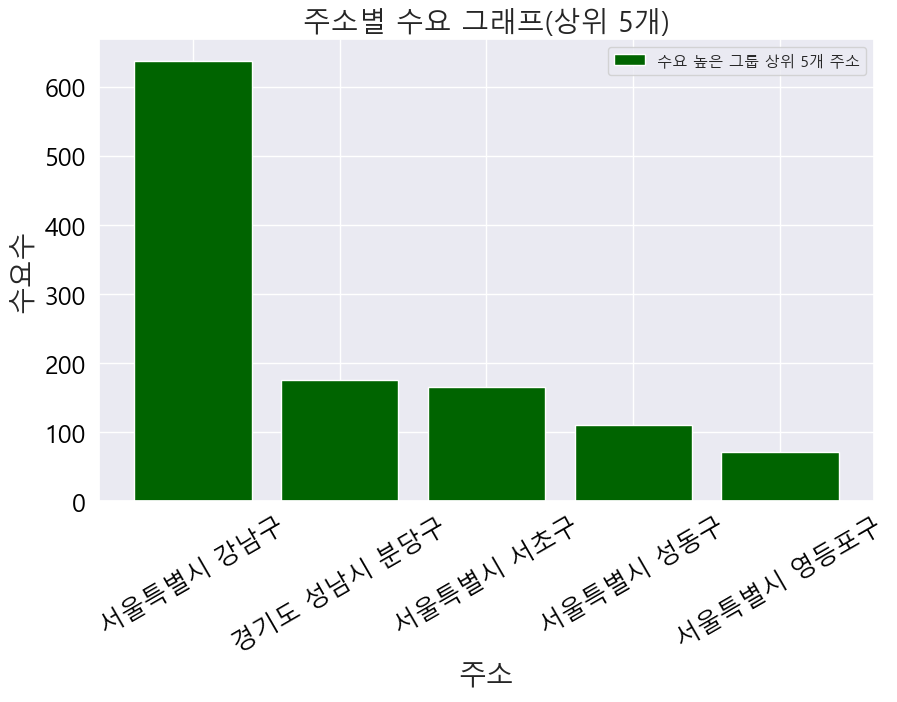

In [25]:
plt.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False
df = pd.DataFrame(data)

# 주소별 기업 개수 계산
address_count = df.loc[df['수요'] == 1, '주소'].value_counts().sort_values(ascending=False)
address_count_1 = df.loc[df['수요'] == 0, '주소'].value_counts().sort_values(ascending=False)

# 상위 5개 주소
top_5_address = address_count.head(5)

# 하위 5개 주소
bottom_5_address = address_count_1.head(4)

# 시각화
plt.figure(figsize=(10, 6))

# 상위 5개 주소 막대 그래프
plt.bar(top_5_address.index, top_5_address.values, color='darkgreen', label='수요 높은 그룹 상위 5개 주소')

plt.xlabel('주소', fontsize=20)
plt.ylabel('수요수', fontsize=20)
plt.title('주소별 수요 그래프(상위 5개)', fontsize=20)
plt.xticks(fontsize=18, rotation=30, color='black')
plt.yticks(fontsize=18, color='black')
plt.grid(True)
plt.legend()
plt.show()

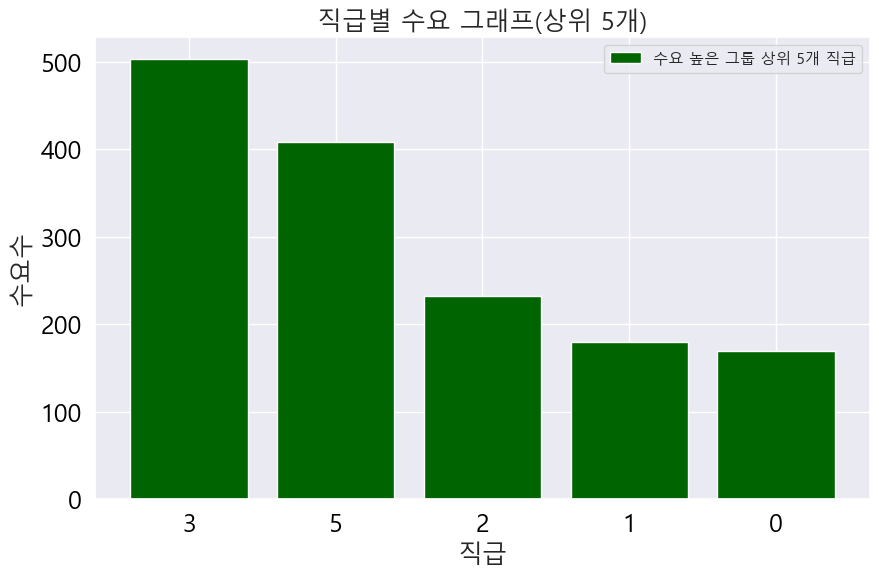

In [26]:
plt.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False
df = pd.DataFrame(data)

# 주소별 기업 개수 계산
car_count = df.loc[df['수요'] == 1, '직급'].value_counts().sort_values(ascending=False)
# 상위 5개 주소
top_5_car = car_count.head(5)


# 시각화
plt.figure(figsize=(10, 6))

# 상위 5개 주소 막대 그래프
plt.bar(top_5_car.index.astype(str), top_5_car.values, color='darkgreen', label='수요 높은 그룹 상위 5개 직급')

plt.xlabel('직급', fontsize=18)
plt.ylabel('수요수', fontsize=18)
plt.title('직급별 수요 그래프(상위 5개)', fontsize=18)
plt.xticks(fontsize=18, color='black')
plt.yticks(fontsize=18, color='black')
plt.grid(True)
plt.legend()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_18136\1209095664.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop.사원수 = df_drop['사원수'].astype(int)


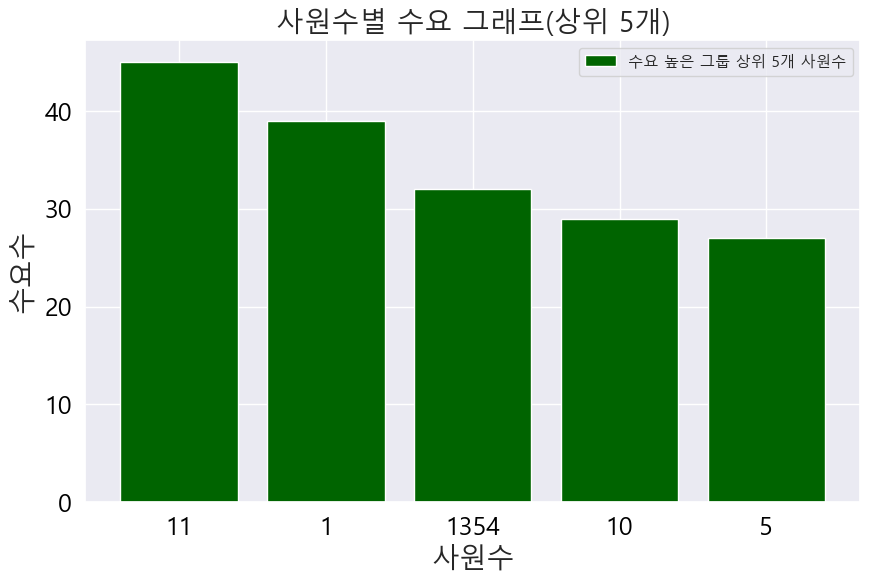

In [27]:
plt.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False
df = pd.DataFrame(data)

df_drop = df.dropna(subset = '사원수')
df_drop.사원수 = df_drop['사원수'].astype(int)

# 주소별 기업 개수 계산
emp_count = df_drop.loc[df_drop['수요'] == 1, '사원수'].value_counts().sort_values(ascending=False)
# 상위 5개 주소
top_5_emp = emp_count.head(5)



# 시각화
plt.figure(figsize=(10, 6))

# 상위 5개 주소 막대 그래프
plt.bar(top_5_emp.index.astype(str), top_5_emp.values, color='darkgreen', label='수요 높은 그룹 상위 5개 사원수')

plt.xlabel('사원수', fontsize=20)
plt.ylabel('수요수', fontsize=20)
plt.title('사원수별 수요 그래프(상위 5개)', fontsize=20)
plt.xticks(fontsize=18, color='black')
plt.yticks(fontsize=18, color='black')
plt.grid(True)
plt.legend()
plt.show()

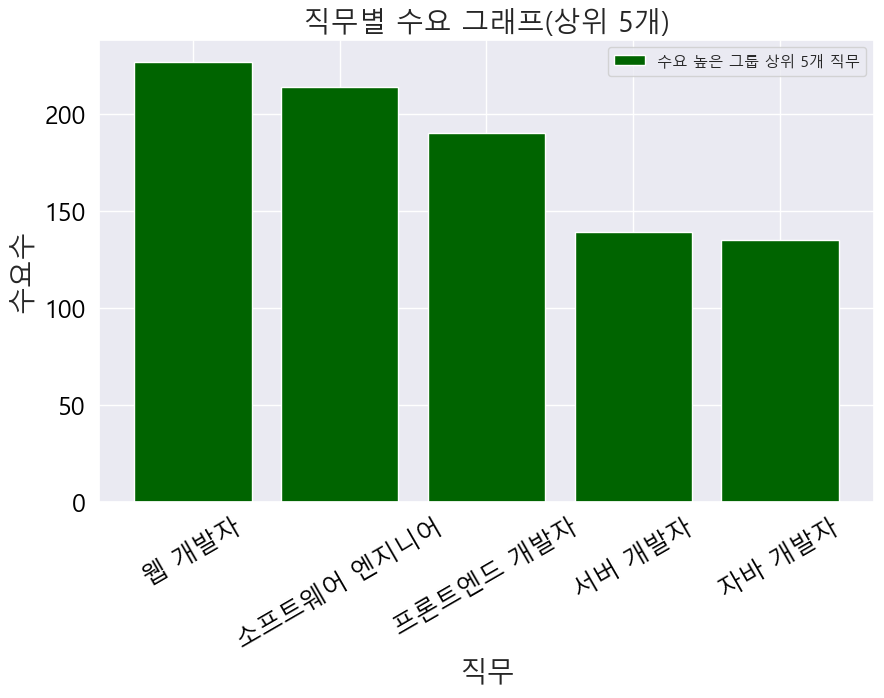

In [32]:
plt.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False
df = pd.DataFrame(data)

# 주소별 기업 개수 계산
job_count = df.loc[df['수요'] == 1, '직무'].value_counts().sort_values(ascending=False)
# 상위 5개 주소
top_5_job = job_count.head(5)



# 시각화
plt.figure(figsize=(10, 6))

# 상위 5개 주소 막대 그래프
plt.bar(top_5_job.index, top_5_job.values, color='darkgreen', label='수요 높은 그룹 상위 5개 직무')

plt.xlabel('직무', fontsize = 20)
plt.ylabel('수요수', fontsize = 20)
plt.title('직무별 수요 그래프(상위 5개)', fontsize = 20)
plt.xticks(fontsize=18, rotation=30, color='black')
plt.yticks(fontsize=18, color='black')
plt.grid(True)
plt.legend()
plt.show()

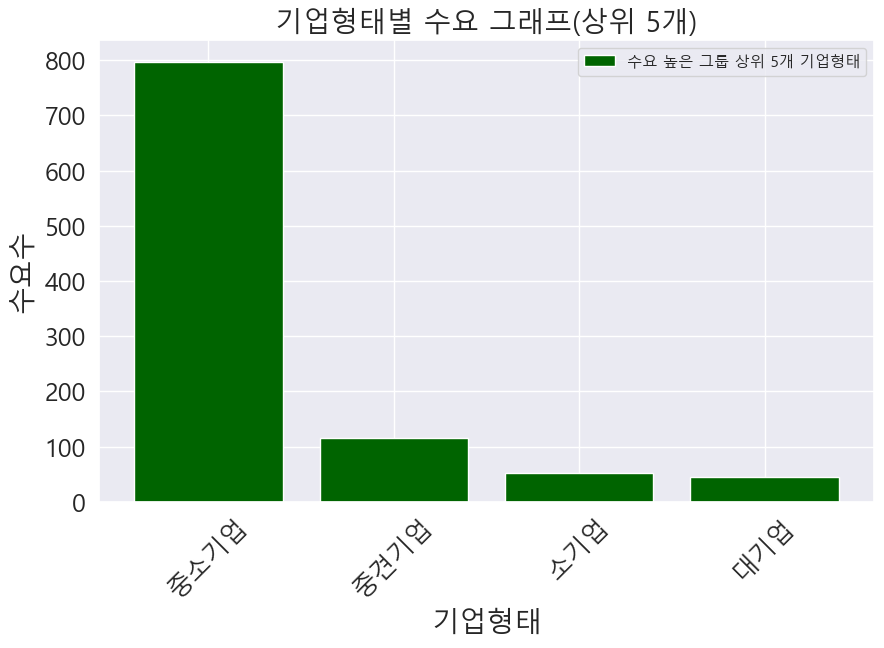

In [33]:
plt.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False
df = pd.DataFrame(data)

# 주소별 기업 개수 계산
corp_count = df.loc[df['수요'] == 1, '기업형태'].value_counts().sort_values(ascending=False)
# 상위 5개 주소
top_5_corp = corp_count.head(5)



# 시각화
plt.figure(figsize=(10, 6))

# 상위 5개 주소 막대 그래프
plt.bar(top_5_corp.index, top_5_corp.values, color='darkgreen', label='수요 높은 그룹 상위 5개 기업형태')

plt.xlabel('기업형태', fontsize = 20)
plt.ylabel('수요수', fontsize = 20)
plt.title('기업형태별 수요 그래프(상위 5개)', fontsize = 20)
plt.xticks(fontsize = 18, rotation=45)
plt.yticks(fontsize = 18)
plt.grid(True)
plt.legend()
plt.show()

In [7]:
data = data.dropna(subset= '이용하는기술스택/우대사항')

In [8]:
tec_list = []

for qqq in data['이용하는기술스택/우대사항']:
    tec_list.append(qqq)

In [9]:
tec_words = ''.join(tec_list).split(',')

In [14]:
sum(1 for aa in tec_words if 'Docker' in aa)

156

In [15]:
len(tec_words)

28167